# Automated Transformations

Automated transformations provide convenient handling of constrained
continuous variables during inference by transforming them to an
unconstrained space. Automated transformations are crucial for
expanding the scope of algorithm classes such as gradient-based Monte
Carlo and variational inference with reparameterization gradients.

A webpage version of this tutorial is available at
http://edwardlib.org/tutorials/automated-transformations.

## The Transform Primitive

Automated transformations in Edward are enabled through the key
primitive
[`ed.transform`](http://edwardlib.org/api/ed/transform).
It takes as input a (possibly constrained) continuous random variable
$\mathbf{x}$, defaults to a choice of transformation $T$, and returns a
[`TransformedDistribution`](http://edwardlib.org/api/ed/models/TransformedDistribution)
$\mathbf{y}=T(\mathbf{x})$ with unconstrained support.
An optional argument allows you to manually specify the transformation.

The returned random variable $\mathbf{y}$'s density is the original
random variable $\mathbf{x}$'s density adjusted by the determinant of
the Jacobian of the inverse transformation (Casella & Berger, 2002),

$$p(\mathbf{y}) = p(\mathbf{x})~|\mathrm{det}~J_{T^{-1}}(\mathbf{y}) |.$$

Intuitively, the Jacobian describes how a transformation warps unit
volumes across spaces. This matters for transformations of random
variables, since probability density functions must always integrate
to one.

## Automated Transformations in Inference

To use automated transformations during inference, set the flag
argument `auto_transform=True` in `inference.initialize`
(or the all-encompassing method `inference.run`):

```python
inference.initialize(auto_transform=True)
```

By default, the flag is already set to `True`.
With this flag, any key-value pair passed into inference's
`latent_vars` with unequal support is transformed to the
unconstrained space; no transformation is applied if already
unconstrained. The algorithm is then run under
`inference.latent_vars`, which explicitly stores the
transformed latent variables and forgets the constrained ones.

We illustrate automated transformations in a few inference examples.
Imagine that the target distribution is a Gamma distribution.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from edward.models import Empirical, Gamma, Normal
from tensorflow.contrib.distributions import bijectors

In [2]:
x = Gamma(1.0, 2.0)

This example is only used for illustration, but note this context of
inference with latent variables of non-negative support occur
frequently: for example, this appears when applying topic models with a deep exponential
family where we might use a normal variational
approximation to implicitly approximate latent variables with Gamma
priors (in
[`examples/deep_exponential_family.py`](https://github.com/blei-lab/edward/blob/master/examples/deep_exponential_family.py),
we explicitly define a non-negative variational approximation).

__Variational inference.__
Consider a Normal variational approximation
and use the algorithm [`ed.KLqp`](http://edwardlib.org/api/ed/KLqp).

In [3]:
qx = Normal(loc=tf.get_variable("qx/loc", []),
            scale=tf.nn.softplus(tf.get_variable("qx/scale", [])))

inference = ed.KLqp({x: qx})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.195


The Gamma and Normal distribution have unequal support, so inference
transforms both to the unconstrained space; normal is already
unconstrained so only Gamma is transformed. `ed.KLqp` then
optimizes with
[reparameterization gradients](http://edwardlib.org/api/klqp).
This means the Normal distribution's parameters are optimized to match
the transformed (unconstrained) Gamma distribution.

Oftentimes we'd like the approximation on the original (constrained)
space. This was never needed for inference, so we must explicitly
build it by first obtaining the target distribution's transformation
and then inverting the transformation:

In [4]:
x_unconstrained = inference.transformations[x]  # transformed prior
x_transform = x_unconstrained.bijector  # transformed prior's transformation
qx_constrained = ed.transform(qx, bijectors.Invert(x_transform))

The set of transformations is given by
`inference.transformations`, which is a dictionary with keys
given by any constrained latent variables and values given by their
transformed distribution. We use the
[`bijectors`](https://www.tensorflow.org/versions/master/api_docs/python/tf/distributions/bijectors)
module in `tf.distributions` in order to handle invertible
transformations.
`qx_unconstrained` is a random variable distributed
according to a inverse-transformed (constrained) normal distribution.
For example, if the automated transformation from non-negative to
reals is $\log$, then the constrained approximation is a LogNormal
distribution; here, the default transformation is the inverse of
$\textrm{softplus}$.

We can visualize the densities of the distributions.
The figure below shows that the inverse-transformed normal
distribution has lighter tails than the Gamma but is overall a
good fit.

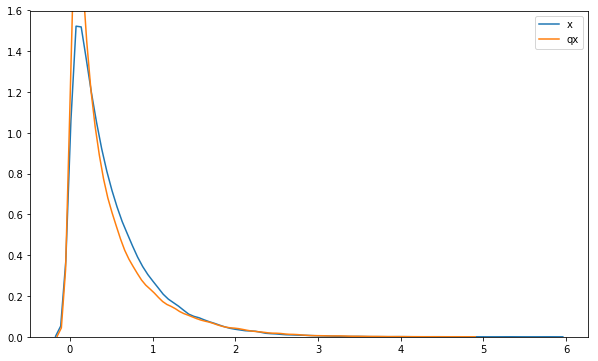

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(x.sample(50000).eval(), hist=False, label='x')
sns.distplot(qx_constrained.sample(100000).eval(), hist=False, label='qx')
plt.show()

__Gradient-based Monte Carlo.__
Consider an Empirical approximation with 1000 samples
and use the algorithm [`ed.HMC`](http://edwardlib.org/api/ed/HMC).

In [6]:
qx = Empirical(params=tf.get_variable("qx/params", [1000]))

inference = ed.HMC({x: qx})
inference.run(step_size=0.8)

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Acceptance Rate: 0.978


Gamma and Empirical have unequal support so Gamma is transformed to
the unconstrained space; by implementation, discrete delta
distributions such as Empirical and PointMass are not transformed.
`ed.HMC` then simulates 
Hamiltonian dynamics and writes the
unconstrained samples to the empirical distribution.

In order to obtain the approximation on the original (constrained)
support, we again take the inverse of the target distribution's
transformation.

In [7]:
x_unconstrained = inference.transformations[x]  # transformed prior
x_transform = x_unconstrained.bijector  # transformed prior's transformation
qx_constrained = Empirical(params=x_transform.inverse(qx.params))

Unlike variational inference, we don't use `ed.transform` to
obtain the constrained approximation, as it only applies to continuous
distributions. Instead, we define a new Empirical distribution whose
parameters (samples) are given by transforming all samples stored in
the unconstrained approximation.

We visualize the densities of the distributions.
The figure below indicates that the samples accurately fit the Gamma
distribution up to simulation error.

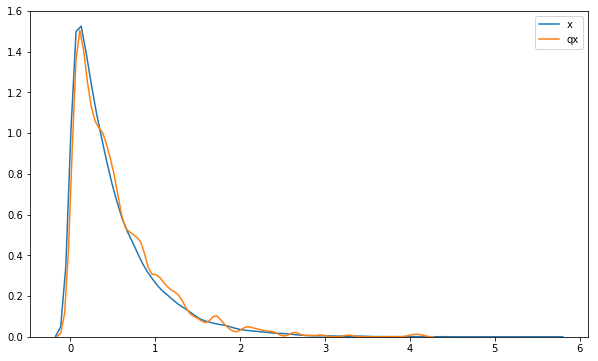

In [8]:
plt.figure(figsize=(10, 6))
sns.distplot(x.sample(50000).eval(), hist=False, label='x')
sns.distplot(qx_constrained.sample(100000).eval(), hist=False, label='qx')
plt.show()

## Acknowledgements & Remarks

Automated transformations have largely been popularized by Stan
for Hamiltonian Monte Carlo (Carpenter et al., 2016).
This design is inspired by Stan's. However, a key distinction is that Edward
provides users the ability to wield transformations and more flexibly
manipulate results in both the original (constrained) and inferred
(unconstrained) space.

Automated transformations are also core to the algorithm automatic
differentiation variational inference (Kucukelbir et al., 2017),
which allows it to select a default variational family of normal
distributions. However, note the automated transformation from
non-negative to reals in Edward is not $\log$, which is used in Stan;
rather, Edward uses $\textrm{softplus}$ which is more numerically
stable (see also Kucukelbir et al. (2017, Fig. 9)).

Finally, note that not all inference algorithms use or even need
automated transformations.
[`ed.Gibbs`](http://edwardlib.org/api/ed/Gibbs), moment
matching with EP using Edward's conjugacy, and
[`ed.KLqp`](http://edwardlib.org/api/ed/KLqp)
with
score function gradients all perform inference on the original latent
variable space.
Point estimation such as [`ed.MAP`](http://edwardlib.org/api/ed/MAP) also
use the original latent variable space and only requires a
constrained transformation on unconstrained free parameters.
Model parameter estimation such as
[`ed.GANInference`](http://edwardlib.org/api/ed/GANInference) do not even
perform inference over latent variables.